/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset cargado: tweet_eval - sentiment
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
                                                text  label
0  "QT @user In the original draft of the 7th boo...      2
1  "Ben Smith / Smith (concussion) remains out of...      1
2  Sorry bout the stream last night I crashed out...      1
3  Chase Headley's RBI double in the 8th inning o...      1
4  @user Alciato: Bee will invest 150 million in ...      2
label
1    20673
2    17849
0     7093
Name: count, dtype: int64


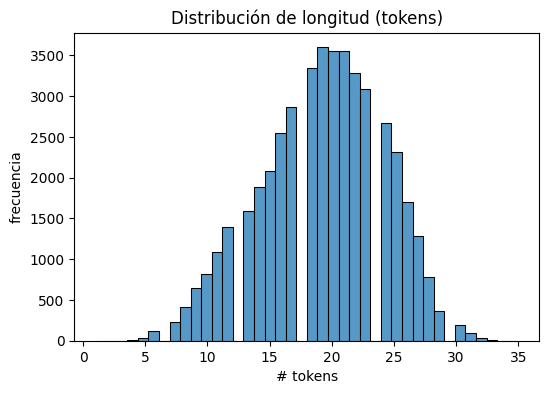

In [2]:
# Instalaciones (Colab)
!pip -q install -U transformers datasets evaluate scikit-learn matplotlib seaborn wordcloud accelerate gensim umap-learn

import os, random, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from datasets import load_dataset

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Carga del dataset de ejemplo (EN)
def load_text_sentiment_dataset():
    # Cambiamos el dataset a uno conocido y público en Hugging Face Hub que no use scripts
    # 'tweet_eval' with 'sentiment' configuration is a good general text classification dataset.
    ds = load_dataset("tweet_eval", "sentiment", trust_remote_code=False)
    return ds, "tweet_eval - sentiment"

raw, source_name = load_text_sentiment_dataset()
print("Dataset cargado:", source_name)
print(raw)

# Normalizar a un DataFrame con columnas: text, label (0=Negative, 1=Neutral, 2=Positive for tweet_eval sentiment)
def normalize_to_text_label(ds, source_name):
    # For tweet_eval, 'train' split is usually available.
    split = "train" if "train" in ds else list(ds.keys())[0]
    df = ds[split].to_pandas()
    # heurísticas de nombre de columna de texto
    text_col_candidates = ["text", "tweet", "content", "sms", "sentence"]
    label_col_candidates = ["label", "labels", "target", "category"]

    text_col = next((c for c in text_col_candidates if c in df.columns), None)
    label_col = next((c for c in label_col_candidates if c in df.columns), None)

    if text_col is None:
        raise ValueError(f"No se encontró columna de texto en {df.columns.tolist()}")
    if label_col is None:
        raise ValueError(f"No se encontró columna de label en {df.columns.tolist()}")

    df = df[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})

    # Labels ya son enteros 0/1/2 en este dataset; si fuesen strings, mapear
    # For tweet_eval sentiment: 0=negative, 1=neutral, 2=positive
    if df["label"].dtype == object:
        # Mapear strings comunes si aplica, e.g., for some datasets:
        # mapping = {"negative": 0, "neutral": 1, "positive": 2}
        # df["label"] = df["label"].map(lambda x: mapping.get(str(x).lower(), x))
        pass # tweet_eval sentiment labels are already integers
    return df

df = normalize_to_text_label(raw, source_name)
df = df.dropna().reset_index(drop=True)

print(df.head())
print(df["label"].value_counts())

# Visualizaciones rápidas
df["length"] = df["text"].str.split().apply(len)
plt.figure(figsize=(6,4))
sns.histplot(df["length"], bins=40)
plt.title("Distribución de longitud (tokens)")
plt.xlabel("# tokens"); plt.ylabel("frecuencia")
plt.show()

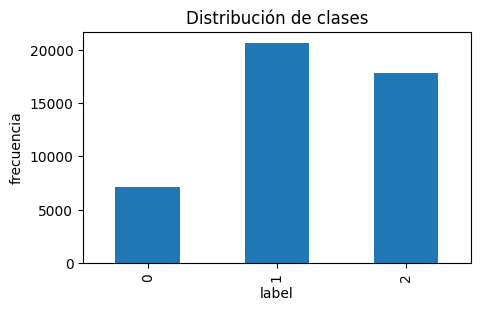


Top n-grams para clase 0:
the: 5800
to: 3250
user: 2597
in: 2014
and: 1971
is: 1898
of: 1849
on: 1784
it: 1665
may: 1573
be: 1351
for: 1320
you: 1294
that: 1152
with: 957
not: 946
tomorrow: 929
he: 907
but: 906
have: 860

Top n-grams para clase 1:
the: 17866
to: 9219
user: 7483
in: 6584
on: 6319
and: 5419
of: 4929
for: 4429
is: 3840
at: 3603
it: 3553
with: 3552
you: 3536
be: 2997
tomorrow: 2938
may: 2906
u002c: 2245
that: 2172
have: 1984
will: 1865

Top n-grams para clase 2:
the: 14337
to: 8483
user: 6760
and: 5309
in: 5113
on: 5018
for: 4243
of: 4118
you: 4032
is: 3968
it: 3859
tomorrow: 3513
with: 3034
be: 2904
at: 2851
my: 2419
may: 2209
day: 2114
this: 1770
that: 1755


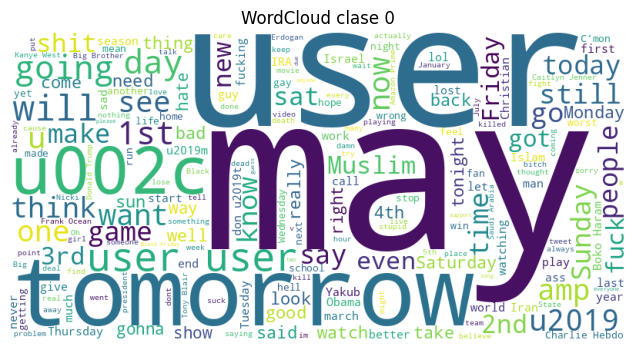

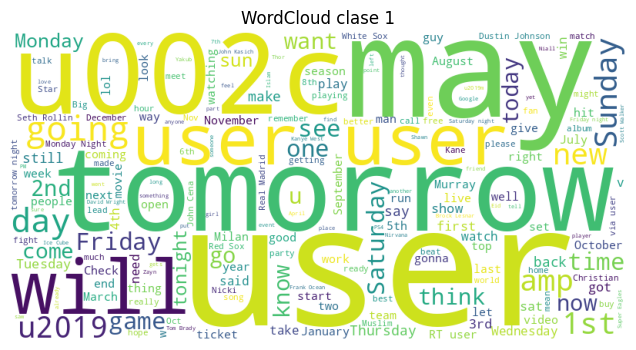

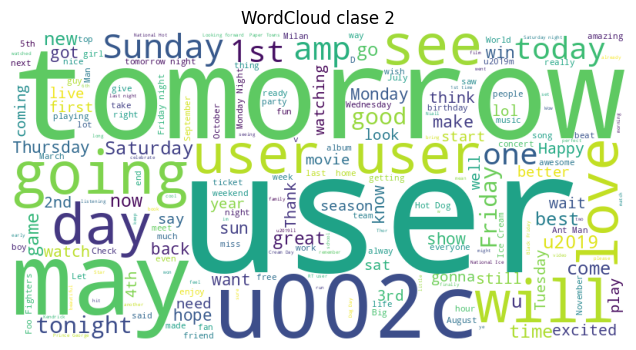

In [3]:
# EDA adicional: distribución de clases
plt.figure(figsize=(5,3))
df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribución de clases"); plt.xlabel("label"); plt.ylabel("frecuencia"); plt.show()

# Top n-grams por clase (BoW rápido)
from sklearn.feature_extraction.text import CountVectorizer
def top_ngrams_per_class(dataframe, label_col, text_col, ngram, topk):
    vec = CountVectorizer(max_features=100000, ngram_range=ngram)
    X = vec.fit_transform(dataframe[text_col])
    vocab = np.array(vec.get_feature_names_out())
    for label_value in sorted(dataframe[label_col].unique()):
        idx = (dataframe[label_col] == label_value).values
        counts = X[idx].sum(axis=0).A1
        top_idx = counts.argsort()[::-1][:topk]
        print(f"\nTop n-grams para clase {label_value}:")
        for token, c in zip(vocab[top_idx], counts[top_idx]):
            print(f"{token}: {c}")

top_ngrams_per_class(df, "label", "text", ngram=(1,2), topk=20)

# WordCloud por clase (si hay clases binarias/multiclase pequeñas)
from wordcloud import WordCloud
for label_value in sorted(df["label"].unique()):
    text_blob = " ".join(df.loc[df["label"] == label_value, "text"].astype(str).tolist())
    wc = WordCloud(width=800, height=400, background_color="white").generate(text_blob)
    plt.figure(figsize=(8,4)); plt.imshow(wc); plt.axis("off"); plt.title(f"WordCloud clase {label_value}"); plt.show()

# PISTAS

# n-grams: (1,2) suele ser un buen comienzo; más alto puede introducir ruido.
# WordCloud: filtrá stopwords si ves términos poco informativos.


In [ ]:
# Proyección TF-IDF con PCA/UMAP para ver separabilidad
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import umap

tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
X = tfidf.fit_transform(df["text"])  # sparse

# PCA a 2D (aprox con truncated SVD si quisieras para sparse; aquí usamos .toarray() si cabe)
try:
    X_dense = X.toarray()
    pca = PCA(n_components=2, random_state=SEED)
    X_pca = pca.fit_transform(X_dense)
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["label"], s=8, palette="tab10", alpha=0.6)
    plt.title("PCA sobre TF-IDF"); plt.legend(bbox_to_anchor=(1.05, 1), loc=2); plt.show()
except Exception:
    pass

# UMAP directamente desde sparse
reducer = umap.UMAP(n_components=2, random_state=SEED, metric="cosine")
X_umap = reducer.fit_transform(X)
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=df["label"], s=8, palette="tab10", alpha=0.6)
plt.title("UMAP sobre TF-IDF"); plt.legend(bbox_to_anchor=(1.05, 1), loc=2); plt.show()

# Word2Vec (exploratorio): vecinos más similares
from gensim.models import Word2Vec
sentences = [t.split() for t in df["text"].astype(str).tolist()]
w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=2, seed=SEED)
for probe in ["insulto", "mierda", "idiota", "respeto"]:
    if probe in w2v.wv:
        print(f"\nVecinos de '{probe}':")
        print(w2v.wv.most_similar(probe, topn=8))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42  # TODO: completar
)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # TODO: completar
clf = LogisticRegression(max_iter=200)  # TODO: completar

from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ("tfidf", vectorizer),
    ("lr", clf)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión — Baseline TF-IDF+LR")
plt.xlabel("Pred"); plt.ylabel("True")
plt.show()


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, ClassLabel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Preparar splits desde pandas (estratificación robusta)
train_df, test_df = train_test_split(
    df[["text", "label"]], test_size=0.2, stratify=df["label"], random_state=SEED
)

train_ds = Dataset.from_pandas(train_df).rename_column("label", "labels")
test_ds = Dataset.from_pandas(test_df).rename_column("label", "labels")

# Asegurar ClassLabel binario cuando es posible
try:
    train_ds = train_ds.cast_column("labels", ClassLabel(num_classes=3))
    test_ds = test_ds.cast_column("labels", ClassLabel(num_classes=3))
except Exception:
    pass

splits = DatasetDict({"train": train_ds, "test": test_ds})

# Modelo en inglés orientado a finanzas; fallback a modelos genéricos
checkpoint_candidates = [
    "ProsusAI/finbert",                    # sugerido
    "bert-base-uncased",                   # TODO: alternativa 1
    "distilbert-base-uncased"              # TODO: alternativa 2
]

def load_first_available_model(candidates):
    last_err = None
    for ck in candidates:
        try:
            tok = AutoTokenizer.from_pretrained(ck)
            mdl = AutoModelForSequenceClassification.from_pretrained(ck, num_labels=3)
            return ck, tok, mdl
        except Exception as e:
            last_err = e
    raise last_err

checkpoint, tokenizer, model = load_first_available_model(checkpoint_candidates)
print("Usando checkpoint:", checkpoint)

# Tokenización BPE: ejemplo rápido
samples = [
    "Esto es inaceptable y ofensivo.",
    "Gran trabajo del equipo, ¡excelente!"
]
for s in samples:
    toks = tokenizer.tokenize(s)
    print(f"\nTexto: {s}\nTokens: {toks}")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

tokenized = splits.map(tokenize, batched=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    unique = np.unique(labels)
    avg = "binary" if len(unique) == 2 else "macro"
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average=avg)
    }

args = TrainingArguments(
    output_dir="outputs",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,                 # TODO
    per_device_train_batch_size=16,     # TODO
    per_device_eval_batch_size=16,      # TODO
    num_train_epochs=4,                 # TODO
    weight_decay=0.01,                  # TODO
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()
results = trainer.evaluate()
print(results)


In [ ]:
# Curvas de métricas por época (si están en el state log)
hist = trainer.state.log_history
acc = [x['eval_accuracy'] for x in hist if 'eval_accuracy' in x]
f1s = [x['eval_f1'] for x in hist if 'eval_f1' in x]

plt.plot(acc, label="Accuracy")
plt.plot(f1s, label="F1")
plt.title("Validación por época")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.legend(); plt.show()

# Comparación simple Baseline vs Transformer
from sklearn.metrics import f1_score, accuracy_score
y_pred_base = pipe.predict(X_test)
base_acc = accuracy_score(y_test, y_pred_base)
base_f1 = f1_score(y_test, y_pred_base, average=("binary" if len(np.unique(y_test))==2 else "macro"))

preds_logits = trainer.predict(tokenized["test"]).predictions
y_pred_tr = preds_logits.argmax(axis=-1)
tr_acc = accuracy_score(tokenized["test"]["labels"], y_pred_tr)
tr_f1 = f1_score(tokenized["test"]["labels"], y_pred_tr, average=("binary" if len(np.unique(tokenized["test"]["labels"]))==2 else "macro"))

print({"baseline": {"acc": base_acc, "f1": base_f1}, "transformer": {"acc": tr_acc, "f1": tr_f1}})